# CEOS Data Cube - NDVI Anomaly Notebook
*****
**Description:** This Python notebook allows users to directly interact with a CEOS-formatted data cube to perform a NDVI anomaly detection analysis. The following steps will allow users to connect to a data cube, define the analysis location and scene of interest (extent of latitude/longitude and dates), and a collection of scenes to use to form a baseline. The output dataset contains a plot of locations where there was a significant change in the NDVI value between the baseline and the scene of interest. This can be extremely useful in identifying areas that are effected by droughts, fires, or deforestation. 
*****

**Import necessary Data Cube libraries and dependencies.**

In [1]:
%matplotlib inline

from ipywidgets import widgets
from IPython.display import display, HTML

import datetime
import collections
import operator
import xarray as xr
import numpy as np
import datacube

from utils.data_cube_utilities.data_access_api import DataAccessApi
import utils.data_cube_utilities.dc_mosaic
from dc_notebook_utilities import *


'Basemap' was not found in 'mpl_toolkits.basemap'.  It is likely that 'mpl_toolkits.basemap' is not present


**First, we must connect to our data cube.** We can then query the contents of the data cube we have connected to, including both the metadata and the actual data. In this application, our data access api class will be used to simplify reading metadata and extent datasets.

In [2]:
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = datacube.Datacube(app='dc-water-analysis', config="/home/localuser/.datacube.conf")


**Obtain the metadata of our cube...** Initially, we need to get the platforms and products in the cube. The rest of the metadata will be dependent on these two options.

In [3]:
products = api.dc.list_products()
platform_names = list(set(products.platform))
product_names = list(products.name)

**Execute the following code and then use the generated form to choose your desired platfrom and product.**

In [4]:
product_values = create_platform_product_gui(platform_names, product_names, dc)

interactive(children=(Select(description='platform', options=('ALOS', 'LANDSAT_5', 'TERRA', 'ALOS_2', 'GPM', 'SENTINEL_1', 'LANDSAT_8', 'LANDSAT_7'), value='ALOS'), Output()), _dom_classes=('widget-interact',))

**After selecting your platform and product, the geographic and time extents will be generated**

This is done with the Data Access API mentioned earlier. After entering a valid geographic and time range, a list of valid acquisitions will be generated.

In [60]:
# Save the form values
platform = product_values[0]
product = product_values[1]

platform, product = platform[0], product[0]

# Get the pixel resolution of the selected product
resolution = products.resolution[products.platform == platform].any()
lat_dist = resolution[0]
lon_dist = resolution[1]

# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product)
min_date = descriptor['time_extents'][0]
min_lat = descriptor['lat_extents'][0]
min_lon = descriptor['lon_extents'][0]

min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)

min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)

max_date = descriptor['time_extents'][1]
max_lat = descriptor['lat_extents'][1] 
max_lon = descriptor['lon_extents'][1] 

max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

max_lat_rounded = round(max_lat, 3) #calculates latitude of the pixel's center
max_lon_rounded = round(max_lon, 3) #calculates longitude of the pixel's center

# Display metadata
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon_dist,
                         min_lat_rounded, max_lat_rounded, lat_dist)

display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

,Min,Max,Resolution
Date:,2014-1-14,2016-12-21,
Longitude:,106.79,108.919,0.000269494585236
Latitude:,10.514,12.611,-0.000269494585236


In [61]:
extent_values = create_extents_gui(min_date_str, max_date_str,
                                   min_lon_rounded, max_lon_rounded,
                                   min_lat_rounded, max_lat_rounded)

##lat = (4.25, 4.75)
##lon = (-71.75, -71.25)

Label(value='Start date: ')

Text(value='')

Label(value='End date: ')

Text(value='')

Label(value='Min lon: ')

BoundedFloatText(value=106.79, max=108.919, min=106.79)

Label(value='Max lon: ')

BoundedFloatText(value=107.79, max=108.919, min=106.79)

Label(value='Min lat: ')

BoundedFloatText(value=10.514, max=12.611, min=10.514)

Label(value='Max lat: ')

BoundedFloatText(value=11.514, max=12.611, min=10.514)

**Now that the area of interest and parameters have been decided, the list of valid acquisitions will be generated**

In [62]:
# Save form values
start_date = datetime.datetime.strptime(extent_values[0].value, '%Y-%m-%d')
end_date = datetime.datetime.strptime(extent_values[1].value, '%Y-%m-%d')
min_lon = extent_values[2].value
max_lon = extent_values[3].value
min_lat = extent_values[4].value
max_lat = extent_values[5].value

acquisitions_list = api.list_acquisition_dates(product, longitude=(min_lon, max_lon), latitude=(min_lat, max_lat))
len(acquisitions_list)

60

**Using the acquisitions list, three drop down menus will be displayed for input.**

The NDVI anomaly function takes three parameters: A single scene to check for anomalies, a list of scenes used to form the baseline, and a percentage threshold. The percentage threshold defines what percentage change between the comparisons constitutes an anomaly. 


In [63]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic, create_median_mosaic, create_max_ndvi_mosaic,create_min_ndvi_mosaic
scene_sel = widgets.Dropdown(options=acquisitions_list,
                                    values=acquisitions_list)

baseline_sel = widgets.SelectMultiple(options=acquisitions_list,
                                    values=acquisitions_list)

threshold_sel_options = {str(x)+'%': x/100 for x in range(5, 101, 5)}
threshold_sel = widgets.Dropdown(options=collections.OrderedDict(sorted(threshold_sel_options.items(), key=operator.itemgetter(1))))

mosaic_methods = {'Most Recent':create_mosaic, 'Least Recent':create_mosaic,
                   'Median':create_median_mosaic, 'Max NDVI':create_max_ndvi_mosaic, 
                   'Min NDVI':create_min_ndvi_mosaic}

mosaic_options_sel = widgets.Dropdown(options=list(mosaic_methods.keys()))
    
# Display form
display(widgets.Label('Select a scene to check for anomalies: '), scene_sel)
display(widgets.Label('Select scenes to form a baseline: '), baseline_sel)
display(widgets.Label('Select a mosaic method for the baseline:  '), mosaic_options_sel)
display(widgets.Label('Select a percentage threshold for anomalies: '), threshold_sel)


Label(value='Select a scene to check for anomalies: ')

Dropdown(options=(datetime.datetime(2014, 1, 14, 3, 8, 50), datetime.datetime(2014, 1, 30, 3, 8, 45), datetime.datetime(2014, 2, 15, 3, 8, 30), datetime.datetime(2014, 3, 3, 3, 8, 14), datetime.datetime(2014, 3, 19, 3, 8, 6), datetime.datetime(2014, 4, 4, 3, 7, 51), datetime.datetime(2014, 4, 20, 3, 7, 34), datetime.datetime(2014, 5, 6, 3, 7, 17), datetime.datetime(2014, 5, 22, 3, 7, 9), datetime.datetime(2014, 6, 7, 3, 7, 19), datetime.datetime(2014, 6, 23, 3, 7, 22), datetime.datetime(2014, 7, 9, 3, 7, 30), datetime.datetime(2014, 7, 25, 3, 7, 32), datetime.datetime(2014, 8, 10, 3, 7, 42), datetime.datetime(2014, 8, 26, 3, 7, 44), datetime.datetime(2014, 9, 11, 3, 7, 48), datetime.datetime(2014, 9, 27, 3, 7, 46), datetime.datetime(2014, 10, 13, 3, 7, 53), datetime.datetime(2014, 10, 29, 3, 7, 49), datetime.datetime(2014, 11, 14, 3, 7, 53), datetime.datetime(2014, 11, 30, 3, 7, 51), datetime.datetime(2014, 12, 16, 3, 7, 46), datetime.datetime(2015, 1, 1, 3, 7, 41), datetime.datetime(2015, 1, 17, 3, 7, 40), datetime.datetime(2015, 2, 2, 3, 7, 36), datetime.datetime(2015, 2, 18, 3, 7, 28), datetime.datetime(2015, 3, 6, 3, 7, 22), datetime.datetime(2015, 3, 22, 3, 7, 13), datetime.datetime(2015, 4, 7, 3, 7, 2), datetime.datetime(2015, 4, 23, 3, 7), datetime.datetime(2015, 5, 9, 3, 6, 44), datetime.datetime(2015, 5, 25, 3, 6, 43), datetime.datetime(2015, 6, 10, 3, 6, 54), datetime.datetime(2015, 7, 28, 3, 7, 16), datetime.datetime(2015, 8, 13, 3, 7, 21), datetime.datetime(2015, 8, 29, 3, 7, 27), datetime.datetime(2015, 9, 30, 3, 7, 40), datetime.datetime(2015, 10, 16, 3, 7, 40), datetime.datetime(2015, 11, 1, 3, 7, 46), datetime.datetime(2015, 11, 17, 3, 7, 47), datetime.datetime(2015, 12, 3, 3, 7, 48), datetime.datetime(2015, 12, 19, 3, 7, 48), datetime.datetime(2016, 1, 4, 3, 7, 45), datetime.datetime(2016, 1, 20, 3, 7, 45), datetime.datetime(2016, 2, 5, 3, 7, 41), datetime.datetime(2016, 3, 8, 3, 7, 32), datetime.datetime(2016, 3, 24, 3, 7, 24), datetime.datetime(2016, 4, 9, 3, 7, 17), datetime.datetime(2016, 4, 25, 3, 7, 10), datetime.datetime(2016, 5, 11, 3, 7, 12), datetime.datetime(2016, 5, 27, 3, 7, 18), datetime.datetime(2016, 6, 12, 3, 7, 21), datetime.datetime(2016, 7, 14, 3, 7, 36), datetime.datetime(2016, 7, 30, 3, 7, 40), datetime.datetime(2016, 8, 15, 3, 7, 43), datetime.datetime(2016, 8, 31, 3, 7, 50), datetime.datetime(2016, 9, 16, 3, 7, 53), datetime.datetime(2016, 11, 19, 3, 8), datetime.datetime(2016, 12, 5, 3, 7, 59), datetime.datetime(2016, 12, 21, 3, 7, 54)), value=datetime.datetime(2014, 1, 14, 3, 8, 50))

Label(value='Select scenes to form a baseline: ')

SelectMultiple(options=(datetime.datetime(2014, 1, 14, 3, 8, 50), datetime.datetime(2014, 1, 30, 3, 8, 45), datetime.datetime(2014, 2, 15, 3, 8, 30), datetime.datetime(2014, 3, 3, 3, 8, 14), datetime.datetime(2014, 3, 19, 3, 8, 6), datetime.datetime(2014, 4, 4, 3, 7, 51), datetime.datetime(2014, 4, 20, 3, 7, 34), datetime.datetime(2014, 5, 6, 3, 7, 17), datetime.datetime(2014, 5, 22, 3, 7, 9), datetime.datetime(2014, 6, 7, 3, 7, 19), datetime.datetime(2014, 6, 23, 3, 7, 22), datetime.datetime(2014, 7, 9, 3, 7, 30), datetime.datetime(2014, 7, 25, 3, 7, 32), datetime.datetime(2014, 8, 10, 3, 7, 42), datetime.datetime(2014, 8, 26, 3, 7, 44), datetime.datetime(2014, 9, 11, 3, 7, 48), datetime.datetime(2014, 9, 27, 3, 7, 46), datetime.datetime(2014, 10, 13, 3, 7, 53), datetime.datetime(2014, 10, 29, 3, 7, 49), datetime.datetime(2014, 11, 14, 3, 7, 53), datetime.datetime(2014, 11, 30, 3, 7, 51), datetime.datetime(2014, 12, 16, 3, 7, 46), datetime.datetime(2015, 1, 1, 3, 7, 41), datetime.datetime(2015, 1, 17, 3, 7, 40), datetime.datetime(2015, 2, 2, 3, 7, 36), datetime.datetime(2015, 2, 18, 3, 7, 28), datetime.datetime(2015, 3, 6, 3, 7, 22), datetime.datetime(2015, 3, 22, 3, 7, 13), datetime.datetime(2015, 4, 7, 3, 7, 2), datetime.datetime(2015, 4, 23, 3, 7), datetime.datetime(2015, 5, 9, 3, 6, 44), datetime.datetime(2015, 5, 25, 3, 6, 43), datetime.datetime(2015, 6, 10, 3, 6, 54), datetime.datetime(2015, 7, 28, 3, 7, 16), datetime.datetime(2015, 8, 13, 3, 7, 21), datetime.datetime(2015, 8, 29, 3, 7, 27), datetime.datetime(2015, 9, 30, 3, 7, 40), datetime.datetime(2015, 10, 16, 3, 7, 40), datetime.datetime(2015, 11, 1, 3, 7, 46), datetime.datetime(2015, 11, 17, 3, 7, 47), datetime.datetime(2015, 12, 3, 3, 7, 48), datetime.datetime(2015, 12, 19, 3, 7, 48), datetime.datetime(2016, 1, 4, 3, 7, 45), datetime.datetime(2016, 1, 20, 3, 7, 45), datetime.datetime(2016, 2, 5, 3, 7, 41), datetime.datetime(2016, 3, 8, 3, 7, 32), datetime.datetime(2016, 3, 24, 3, 7, 24), datetime.datetime(2016, 4, 9, 3, 7, 17), datetime.datetime(2016, 4, 25, 3, 7, 10), datetime.datetime(2016, 5, 11, 3, 7, 12), datetime.datetime(2016, 5, 27, 3, 7, 18), datetime.datetime(2016, 6, 12, 3, 7, 21), datetime.datetime(2016, 7, 14, 3, 7, 36), datetime.datetime(2016, 7, 30, 3, 7, 40), datetime.datetime(2016, 8, 15, 3, 7, 43), datetime.datetime(2016, 8, 31, 3, 7, 50), datetime.datetime(2016, 9, 16, 3, 7, 53), datetime.datetime(2016, 11, 19, 3, 8), datetime.datetime(2016, 12, 5, 3, 7, 59), datetime.datetime(2016, 12, 21, 3, 7, 54)), value=())

Label(value='Select a mosaic method for the baseline:  ')

Dropdown(options=('Least Recent', 'Most Recent', 'Min NDVI', 'Max NDVI', 'Median'), value='Least Recent')

Label(value='Select a percentage threshold for anomalies: ')

Dropdown(options=OrderedDict([('5%', 0.05), ('10%', 0.1), ('15%', 0.15), ('20%', 0.2), ('25%', 0.25), ('30%', 0.3), ('35%', 0.35), ('40%', 0.4), ('45%', 0.45), ('50%', 0.5), ('55%', 0.55), ('60%', 0.6), ('65%', 0.65), ('70%', 0.7), ('75%', 0.75), ('80%', 0.8), ('85%', 0.85), ('90%', 0.9), ('95%', 0.95), ('100%', 1.0)]), value=0.05)

In [64]:
scene = api.get_dataset_by_extent(product, latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), 
                                    time=(scene_sel.value, scene_sel.value+datetime.timedelta(seconds=1)),
                                    measurements=['red', 'nir', 'pixel_qa'])

In [65]:
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa, ls5_unpack_qa

def create_clean_mask(dataset):

    if(platform == "LANDSAT_7"):
        clear_xarray  = ls7_unpack_qa(dataset.pixel_qa, "clear")  
        water_xarray  = ls7_unpack_qa(dataset.pixel_qa, "water")
    elif(platform == "LANDSAT_8"):
        clear_xarray  = ls8_unpack_qa(dataset.pixel_qa, "clear")  
        water_xarray  = ls8_unpack_qa(dataset.pixel_qa, "water")
    
    return np.logical_or(clear_xarray.values.astype(bool), water_xarray.values.astype(bool))

clean_mask = create_clean_mask(scene)

In [66]:

scene_cleaned = create_mosaic(scene, reverse_time=False, clean_mask=clean_mask)

baseline_mosaic = None
reverse_time = True if mosaic_options_sel.value.title() == 'Most Recent' else False
for index in range(len(baseline_sel.value)):
    data = api.get_dataset_by_extent(product, latitude=(min_lat, max_lat), longitude=(min_lon, max_lon), 
                                    time=(baseline_sel.value[index],(baseline_sel.value[index+1] if index != len(baseline_sel.value)-1 else baseline_sel.value[index]+datetime.timedelta(seconds=1))),
                                    measurements=['red', 'nir', 'pixel_qa'])
    clean_mask = create_clean_mask(data)
    baseline_mosaic = mosaic_methods[mosaic_options_sel.value](data, intermediate_product=baseline_mosaic, reverse_time=reverse_time, clean_mask=clean_mask)

**Now that the scene and baseline have been loaded, compute the NDVI for both.**

We will also filter out no data values from the NDVI data arrays.

In [67]:
ndvi_baseline = (baseline_mosaic.nir - baseline_mosaic.red) / (baseline_mosaic.nir + baseline_mosaic.red)
ndvi_scene = (scene_cleaned.nir - scene_cleaned.red) / (scene_cleaned.nir + scene_cleaned.red)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/variable.py:1143: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive


In [68]:
ndvi_baseline.values[scene_cleaned.red.values == -9999] = -9999
ndvi_baseline.values[baseline_mosaic.red.values == -9999] = -9999
ndvi_scene.values[scene_cleaned.red.values == -9999] = -9999
ndvi_scene.values[baseline_mosaic.red.values == -9999] = -9999

Percentage change is calculated as usual using standard python operators on the xarrays. A new xarray is computed where the percentage change exceeds the threshold.

In [69]:
percentage_change = abs((ndvi_baseline - ndvi_scene) / ndvi_baseline)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/variable.py:1143: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


In [70]:
anomalies = percentage_change.where(percentage_change > threshold_sel.value)
anomalies

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.9.5-py3.5.egg/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray (latitude: 3712, longitude: 3711)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 11.51 11.51 11.51 11.51 11.51 11.51 11.51 ...
  * longitude  (longitude) float64 106.8 106.8 106.8 106.8 106.8 106.8 106.8 ...

**The anomalies are visualized below.**
Any pixel that has a difference exceeding the defined threshold will be colored, while the unchanged pixels are white. This result can be manipulated by changing the baseline scheme. For example, if the chosen scene is in January you can select only January scenes as your baseline, or expand that to the first few months of the year.

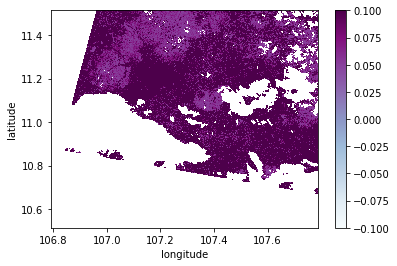

In [71]:
anomalies_plot = anomalies.plot(cmap='BuPu')